## Imports

In [1]:
import sys
import os

current_dir = os.getcwd() 
sys.path.append(os.path.join(current_dir, '..'))

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Traffic Signal Controller Reinforcement Learning Modules
from tscRL.environments.environment import SumoEnvironment, TrafficLight as tl
from tscRL.agents import ql_agent, fixedTL_agent as ftl_agent

# Include sumo-tools directory
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")



## Hyperparameter tuning

### Epsilon Greedy Policy

#### Estrategias para decaer Epsilon en Epsilon-Greedy 

In [2]:
# Exponencial
def calculate_exp_epsilon(decayRate, steps, startEpsilon=1.0, endEpsilon=0.001):
    x = np.arange(steps)
    y = endEpsilon + (startEpsilon - endEpsilon) * np.exp(-decayRate * x)
    return x, y

# Lineal
def calculate_linear_epsilon(steps, startEpsilon=1.0, endEpsilon=0.001):
    slope = (startEpsilon - endEpsilon) / steps
    x = np.arange(steps)
    y = startEpsilon - slope * x
    y = np.maximum(y, endEpsilon)  # Asegura que el valor mínimo sea endEpsilon
    return x, y

#### Decay rates
Rasa con la que decae epsilon a través de los pasos de tiempo (steps)

In [3]:
decay_rates = [0.01, 0.02, 0.025, 0.03, 0.05]

#### Análisis de funciones epsilon a través del tiempo

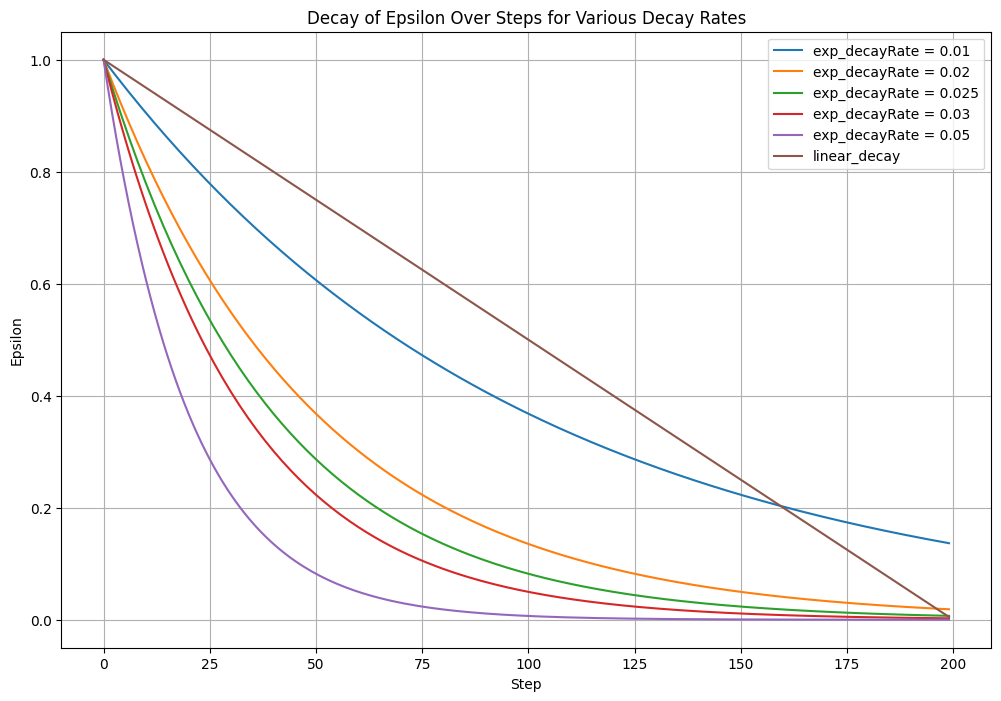

In [4]:
episodes = 200

endEpsilon = 0.01
startEpsilon = 1

plt.figure(figsize=(12, 8))

for decayRate in decay_rates:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')

x, y = calculate_linear_epsilon(episodes)
plt.plot(x, y, label=f'linear_decay')

plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
decay_rates = [0.02, 0.03]

### Q-Learning - Parámetros

#### Delta time
Tiempo de simulación (en segundos) entre pasos (steps)

In [6]:
delta_times = [5]

#### Phases
Posibles fases de un semáforo. Determina el espacio de acción (action space)

In [7]:
phases = [{'init':   tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'ns_sn_l':   tl.Phase("GGGgrrrrGGGgrrrr", "yyyyrrrryyyyrrrr"), #
        'ew_we_l':   tl.Phase("rrrrGGGgrrrrGGGg", "rrrryyyyrrrryyyy"), #
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),
        'ne_sw':     tl.Phase("rrrGrrrrrrrGrrrr", "rrryrrrrrrryrrrr"),   #
        'wn_es':     tl.Phase("rrrrrrrGrrrrrrrG", "rrrrrrryrrrrrrry")    #
        }]
             

#### Edges
Parámetro que determina si se usaran aristas (edges), en vez de carriles (lanes). En la siguiente figura se puede observar la diferencia


<div style="text-align:center;"><img src="./images/lane_vs_edge.png" alt="lane vs edge" width="800"></div>





In [8]:
edges = [False, True]

#### Intervalos de codificación
Cantidad de intervalos que se usarán para codificar (discretizar) los estados.


In [9]:
encode_intervals = [10, 16]

#### Función de recompensa
Para computar la recompensa se cuenta con dos funciones:
- Diferencia de sumatoria de todos los tiempos de espera (*diff_waitingTime*)
- Diferencia de vehículos detenidos (*diff_halted*)

In [10]:
# rewardFn = ["diff_halted", "diff_waitingTime"]
reward_fns = list(SumoEnvironment.rewardFns.keys())

#### Lane Info
Que información es más relevante para capturar el estado de tráfico en un carril (o arista)?

In [11]:
lane_info = ["halted", "waitingTime"]

## Semáforos estáticos

In [12]:
sumoCfgFile = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/interseccion2.sumocfg'))

env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=6, laneInfo="waitingTime", rewardFn="diff_waitingTime", fixedTL=True)

agent = ftl_agent.FixedTLAgent(env, 5)

ftl_agent_metrics = agent.run();

df = pd.DataFrame(ftl_agent_metrics)
df



 Retrying in 1 seconds
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5


,episode,cumulative_reward,mean_waiting_time
0,0,-1659.0,18.498650
1,1,-781.0,18.411823
2,2,278.0,18.604418
3,3,-183.0,18.537155
4,4,232.0,18.572630


In [ ]:
df = pd.DataFrame(ftl_agent_metrics)
df

In [ ]:
avg_waiting_time_df = df.groupby('episode')['mean_waiting_time'].mean()
df = avg_waiting_time_df
df

In [ ]:
plt.plot(df['episode'], df['mean_waiting_time'])
plt.xlabel('episode')
plt.ylabel('mean_waiting_time')
plt.title('Gráfico')
plt.grid(True)
plt.show()

In [12]:
param_grid = {
    "lane_info": lane_info,
    "reward_fns": reward_fns,
    "encode_intervals": encode_intervals,
    "phases": phases,
    "decay_rates": decay_rates
}

In [13]:
sumoCfgFile = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/interseccion2.sumocfg'))

results = []
result = {"params": None, "metrics": None}
for encode_interval in param_grid["encode_intervals"]:
    for lane_info in param_grid["lane_info"]:
        for reward_fn in param_grid["reward_fns"]:
            for decay_rate in param_grid["decay_rates"]:
                env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn)
                agent = ql_agent.QLAgent(enviroment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=decayRate, episodes=50)
                metrics = agent.train();
                params = "encode_interval:" + str(encode_interval) + ",lane_info:" + str(lane_info) + ",reward_fns:" + str(reward_fn) + ",decay_rate:" + str(decay_rate)
                results.append({"params": params, "metrics": metrics })


 Retrying in 1 seconds
episode: 1


episode: 2


episode: 3


episode: 4


KeyboardInterrupt: 

In [15]:
resultsParamExploration_1 = results


Step #600.00 (1ms ~= 1000.00*RT, ~34000.00UPS, TraCI: 56ms, vehicles TOT 389 ACT 34 BUF 0)


In [16]:
def split_long_string(s, max_length):
    words = s.split(',')
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += ("," if current_line else "") + word
        else:
            lines.append(current_line)
            current_line = word
    lines.append(current_line)
    return "\n".join(lines)

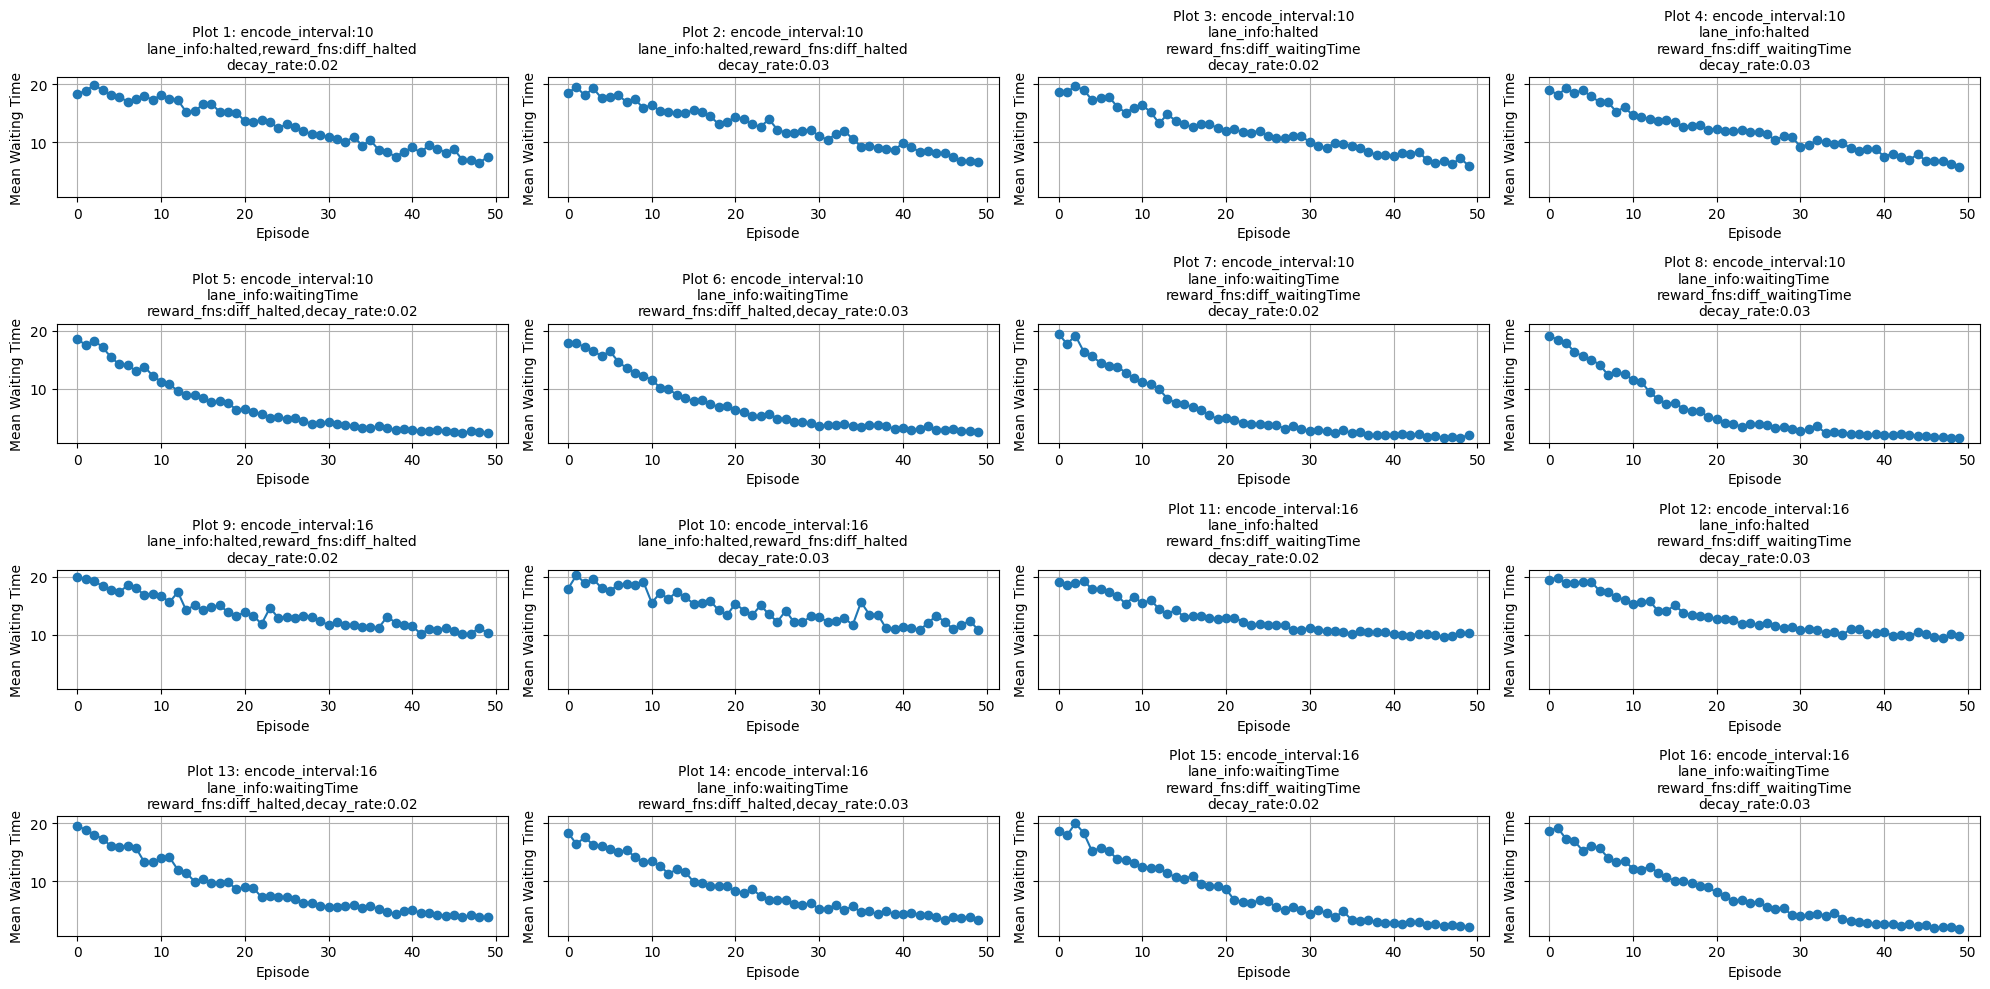

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(20,10), sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(resultsParamExploration_1):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()
    

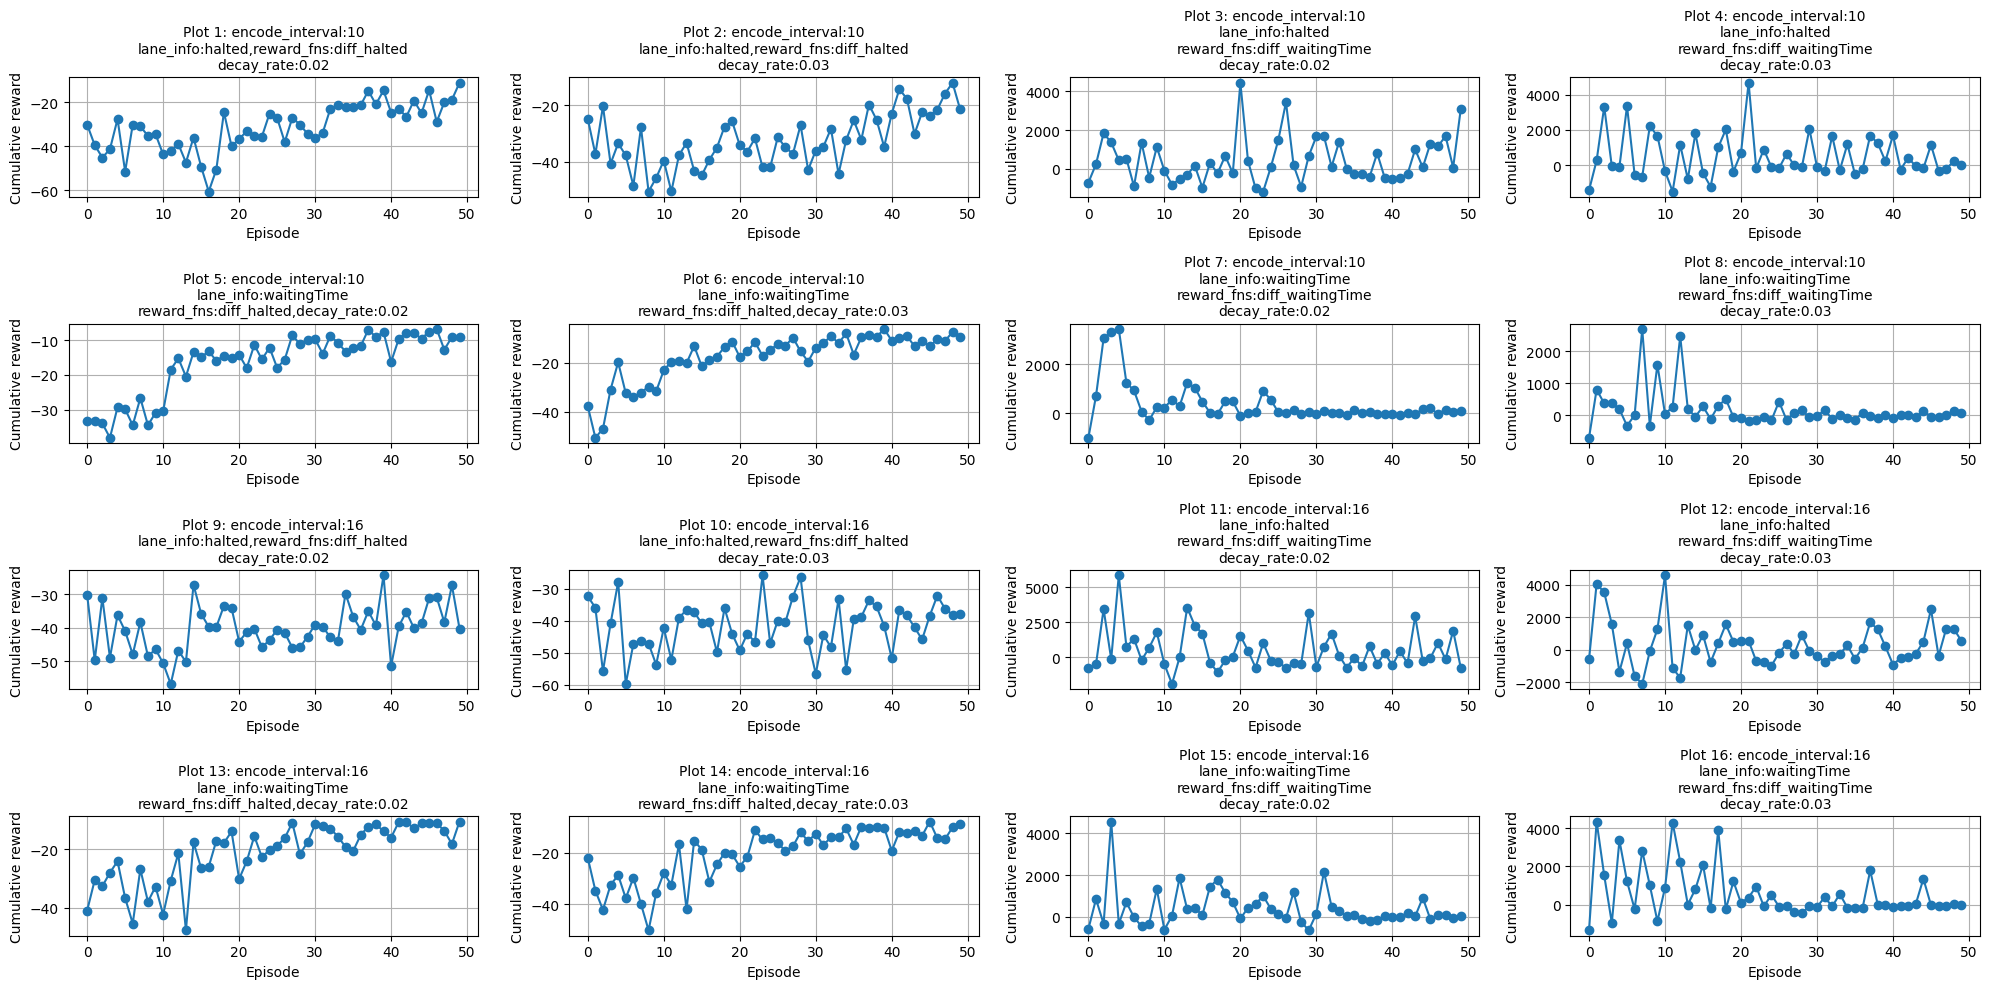

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(20,10))
axes = axes.flatten()

dfs = []
for i, result in enumerate(resultsParamExploration_1):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['cumulative_reward'], marker='o')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Cumulative reward')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
results = []
result = {"params": None, "metrics": None}
for encode_interval in param_grid["encode_intervals"]:
    for decay_rate in param_grid["decay_rates"]:
        env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo="waitingTime", rewardFn="diff_waitingTime")
        ql_agent.QLAgent(enviroment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=decayRate, episodes=50)
        metrics = agent.train();
        params = "encode_interval:" + str(encode_interval) + ",decay_rate:" + str(decay_rate)
        results.append({"params": params, "metrics": metrics })

In [20]:
resultsParamExploration_2 = results

Step #600.00 (0ms ?*RT. ?UPS, TraCI: 52ms, vehicles TOT 389 ACT 34 BUF 0)                 


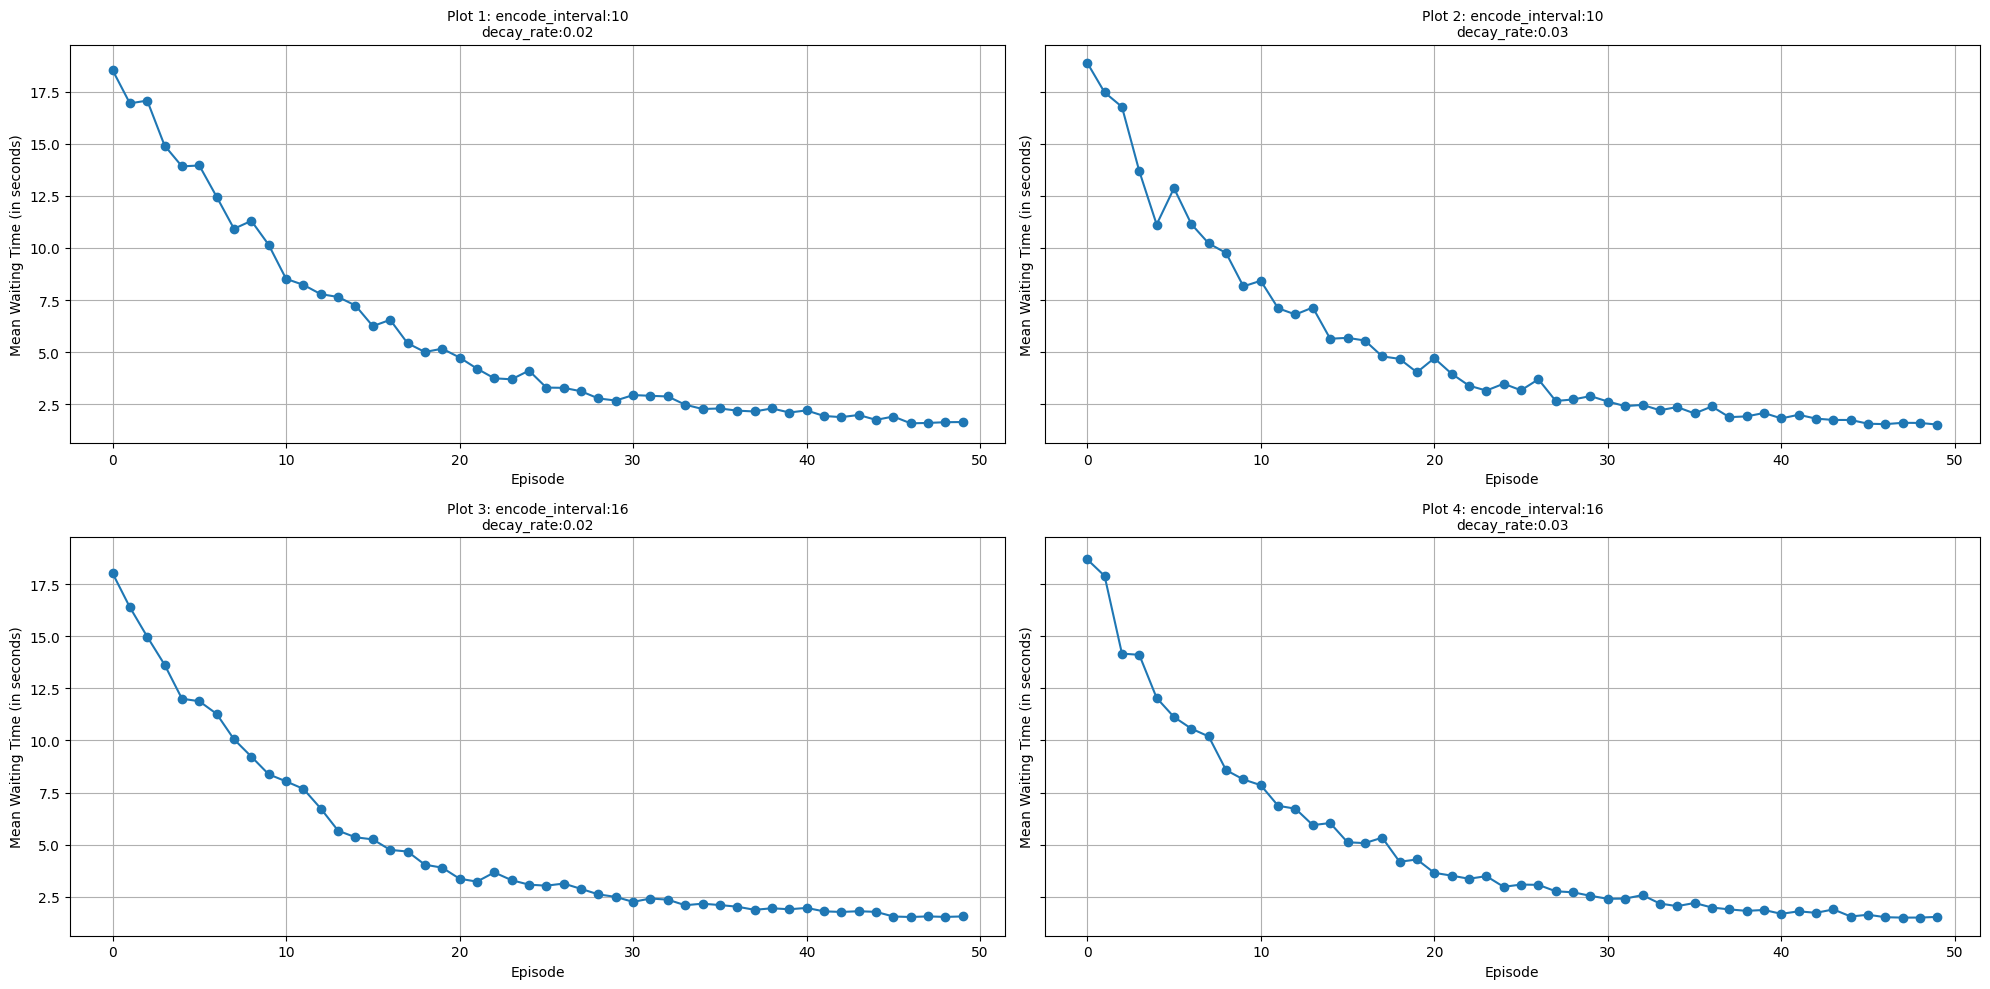

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20,10),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(resultsParamExploration_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

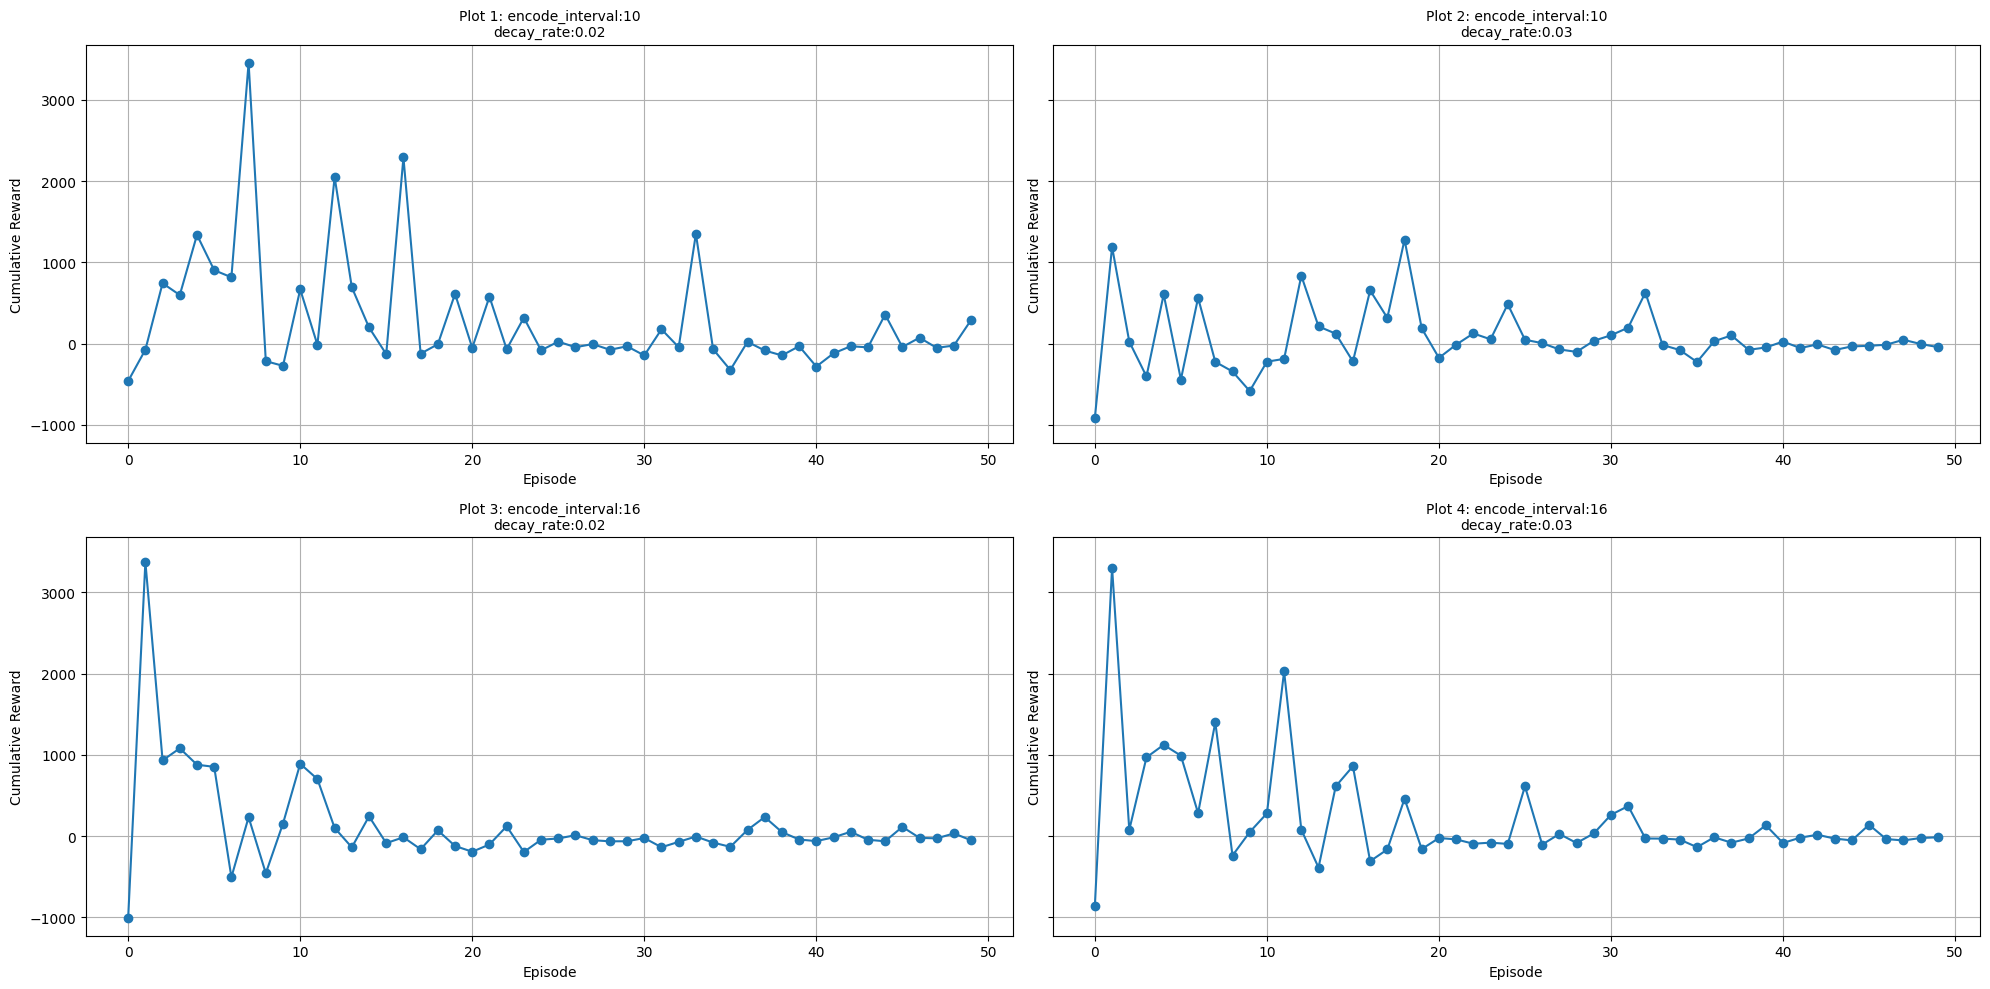

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(20,10),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(resultsParamExploration_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['cumulative_reward'], marker='o')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Cumulative Reward')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

### Learning rates


In [23]:
learning_rates = [0.1, 0.01, 0.001]

In [ ]:
results = []
result = {"params": None, "metrics": None}
for learning_rate in learning_rates:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=10, laneInfo="waitingTime", rewardFn="diff_waitingTime")
    agent = ql_agent.QLAgent(enviroment=env, gamma=0.99, alpha=learning_rate, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=50)
    metrics = agent.train();
    params = "learning_rate:" + str(learning_rate)
    results.append({"params": params, "metrics": metrics })

In [25]:
resultsParamExploration_3 = results

Step #600.00 (0ms ?*RT. ?UPS, TraCI: 53ms, vehicles TOT 389 ACT 34 BUF 0)                 


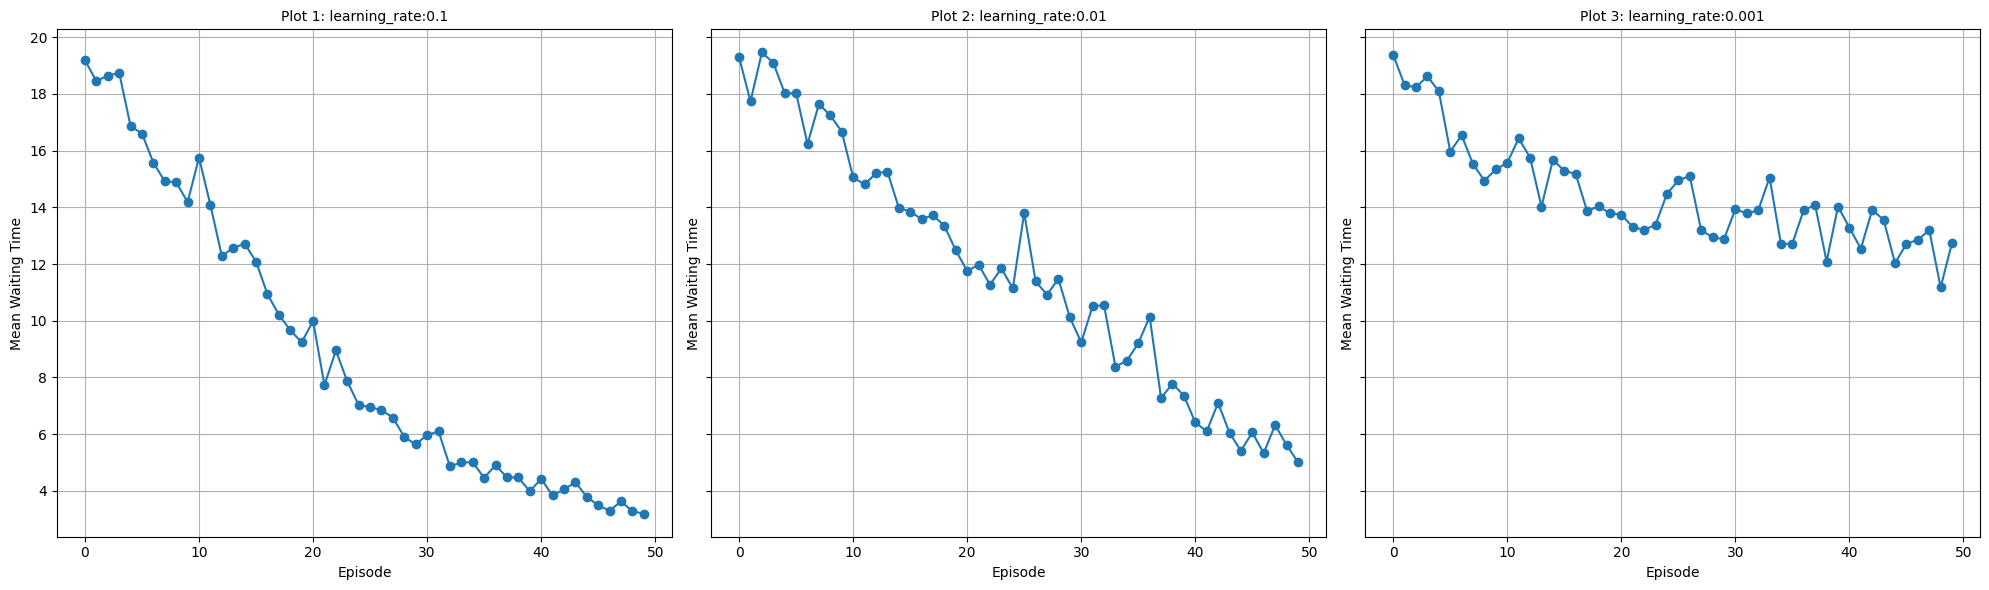

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20,6),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(resultsParamExploration_3):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=10, laneInfo="waitingTime", rewardFn="diff_waitingTime")
agent = ql_agent.QLAgent(enviroment=env, gamma=0.99, alpha=0.001, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=100)
metrics = agent.train();



Step #43805.00 (1ms ~= 1000.00*RT, ~34000.00UPS, TraCI: 52ms, vehicles TOT 389 ACT 34 BUF 0)


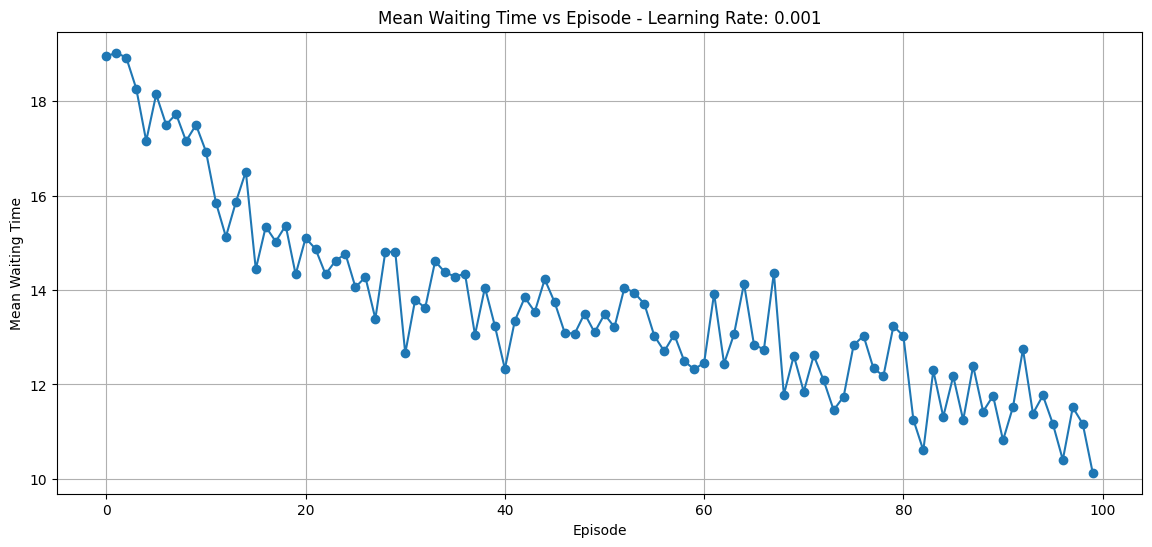

In [28]:
df = pd.DataFrame(metrics)
plt.figure(figsize=(14, 6))
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time')
plt.title('Mean Waiting Time vs Episode - Learning Rate: 0.001')

plt.grid(True)

In [ ]:
sumoCfgFile = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/interseccion2.sumocfg'))
env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=10, laneInfo="waitingTime", rewardFn="diff_waitingTime")
agent = ql_agent.QLAgent(enviroment=env, gamma=0.99, alpha=0.01, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=200)
metrics = agent.train();


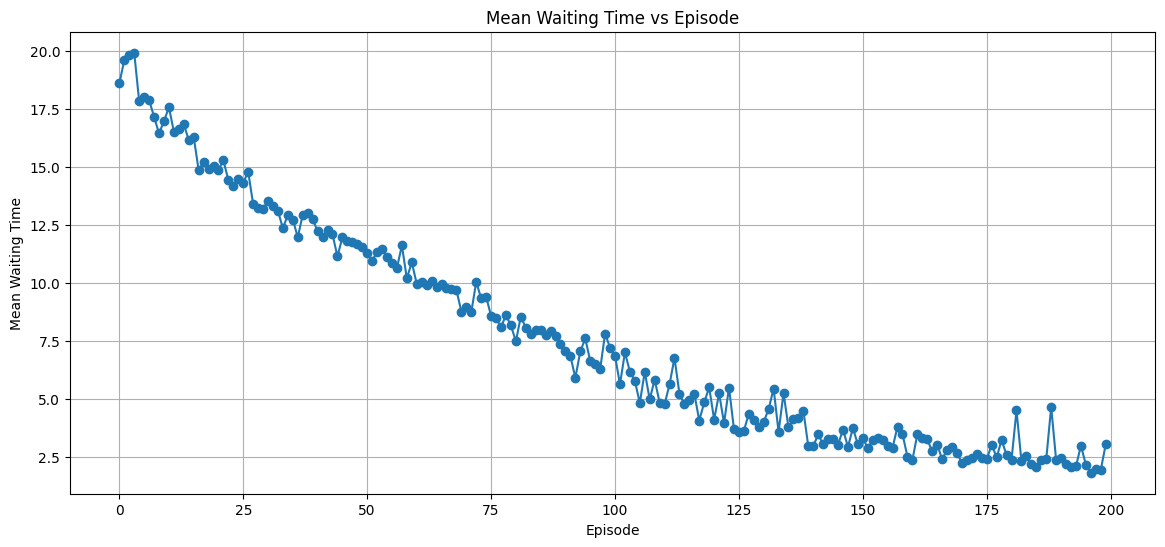

In [17]:
df = pd.DataFrame(metrics)
plt.figure(figsize=(14, 6))
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time')
plt.title('Mean Waiting Time vs Episode')

plt.grid(True)

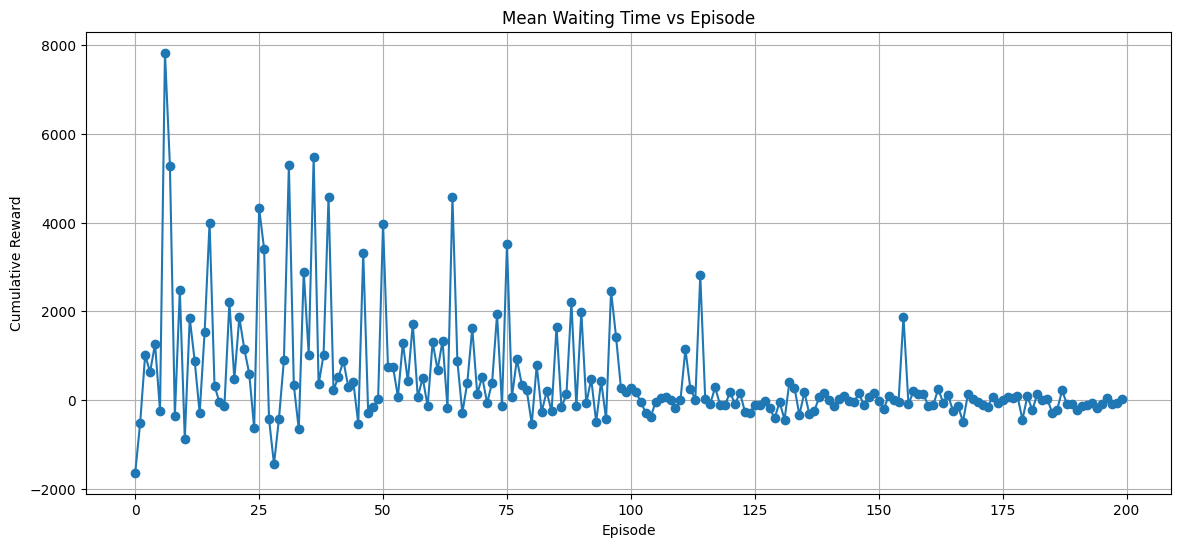

In [19]:
df = pd.DataFrame(metrics)
plt.figure(figsize=(14, 6))
plt.plot(df['episode'], df['cumulative_reward'], marker='o')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward')

plt.grid(True)